#  NLP- Sentimiento en reseñas IMDB

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [ ]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm import tqdm_notebook
from tqdm.auto import tqdm

from collections import Counter
import nltk
from nltk.corpus import stopwords
import re
import spacy
from spacy.lang.en.examples import sentences
!python -m spacy download en_core_web_sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8-deep')

In [11]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [15]:
# Tokenizador de spacy (incluye lematización)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

## Cargar datos

In [16]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [17]:
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
17317,tt0455538,movie,How to Lose Friends & Alienate People,How to Lose Friends & Alienate People,2008,\N,110,0,"Biography,Comedy,Drama",6.4,67071,"Not that he'd care, but I'm not one of Simon P...",4,neg,0,train,2932
37724,tt0443527,movie,The Hamiltons,The Hamiltons,2006,\N,86,0,"Drama,Horror,Thriller",5.1,8353,"When a film is independent and not rated, such...",1,neg,0,train,5176
14893,tt0101969,movie,Grand Canyon,Grand Canyon,1991,\N,134,0,"Crime,Drama",6.9,14440,... but watch Mary McDonnell's performance clo...,8,pos,1,train,4302
2040,tt0086663,tvSeries,All the Rivers Run,All the Rivers Run,1983,1990,400,0,"Drama,Romance",7.6,566,I first saw All the Rivers Run on TV when I wa...,10,pos,1,test,11624
30439,tt0850642,tvSeries,Shaggy & Scooby-Doo Get a Clue!,Shaggy & Scooby-Doo Get a Clue!,2006,2008,\N,0,"Action,Adventure,Animation",4.6,739,Shaggy & Scooby-Doo Get a Clue. It's like watc...,1,neg,0,train,1948
31733,tt0108186,movie,Son in Law,Son in Law,1993,\N,95,0,"Comedy,Drama,Romance",5.8,16996,This is the only Pauly Shore movie you should ...,7,pos,1,test,6289
18247,tt0125802,video,Invisible Dad,Invisible Dad,1998,\N,90,0,"Comedy,Fantasy,Sci-Fi",3.1,245,"Okay, it's a movie for children, and it's not ...",1,neg,0,test,10624
25595,tt0086071,tvMovie,Packin' It In,Packin' It In,1983,\N,95,0,"Comedy,Drama,Family",5.9,150,I first watched this movie back in the mid/lat...,3,neg,0,test,115
35159,tt0066863,movie,The Brotherhood of Satan,The Brotherhood of Satan,1971,\N,92,0,Horror,5.4,1224,This mess starts off with a real tank running ...,1,neg,0,test,1363
8625,tt0189456,movie,Cut,Cut,2000,\N,82,0,"Comedy,Horror,Mystery",4.2,3161,It seems that several of the people who have r...,1,neg,0,train,3464


In [18]:
df_reviews.head(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


Importancia de hacer el head y también el sample. COn el head pude detectar que hay filas las cuales son casi idénticas. Esto es de esperarse, pues si se está revisando, por ejemplo, el título '15', la información para este será siempre el mismo, y la diferencia se encuentra en las reseñas.

A partir de esto puedo inferir, que, los valores duplicados son un problema, pero habrá celdas que a pesar de ser casi iguales, seguramente diferirán en la columna ['review']. Las reseñas y en general el dataset está en inglés.

In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [21]:
df_reviews.describe()   

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


In [22]:
# Duplicados explícitos 
duplicados = df_reviews.duplicated().sum()
print(f'Número de filas duplicadas: {duplicados}')

# Valores NaNs
ausentes = df_reviews.isna().sum()
df_reviews.dropna(inplace=True)
ausentes = df_reviews.isna().sum()
print(f'Número de filas con valores ausentes: {ausentes.sum()}')

Número de filas duplicadas: 0
Número de filas con valores ausentes: 0


In [23]:
# Verificar la distribución de clases empezando por ds_part (train/test)
display(df_reviews['ds_part'].value_counts(normalize=True)) # Existe un balace muy bueno.

# Verificar la distribución de clases en pos (positivo/negativo)
display(df_reviews['pos'].value_counts(normalize=True)) # Existe un balance, casi en la misma proporción.

# Verificar la distribución de clases en rating (1-10)
display(df_reviews['rating'].value_counts(normalize=True).sort_index()) # La mayoría de las calificaciones son 7, 8 y 9. Hay muy pocas calificaciones bajas.


ds_part
train    0.502778
test     0.497222
Name: proportion, dtype: float64

pos
0    0.501067
1    0.498933
Name: proportion, dtype: float64

rating
1     0.202603
2     0.091677
3     0.099495
4     0.107292
7     0.097044
8     0.117814
9     0.091741
10    0.192335
Name: proportion, dtype: float64

In [24]:
# Verificar si la columna rating corresponde con los valores de pos
df_reviews['rating'].corr(df_reviews['pos']) # La correlación es muy alta, lo cual es esperable, pues la columna 'pos' se deriva de 'rating'.

np.float64(0.9412290207484465)

Estudiando un poco más a detalle el dataset tenemos datos muy interesantes. Los valores ausentes y las filas dupllicadas explícitamente eran pocas (decenas de un total de miles) por lo que simplemente eliminarlas fue una decisión sencilla.
En la descripción del proyecto, no obtuvimos un glosario que nos permita conocer a detalle o a ciencia cierta qué representan los valores de cada columna, por lo que con criterio e investigación externa se intentó hacer una comprensión más profunda de los datos, para verificar qué tan útiles son las columnas.

En ejemplo claro es la columna ['idx'] y se encontró que: En datos de IMDB estas son las siglas para  un identificador interno de la reseña, básicamente un índice numérico que los autores del dataset asignaron a cada fila, por lo cual, asigna un valor único para cada registro, sin embargo, no proporciona ningún valor predictivo a los modelos que se entrenarán posteriormente, por lo que eliminar esta columna pudiera ser una bena idea.


In [25]:
display(df_reviews['idx'].duplicated().sum() )
display((f'Existen {df_reviews["idx"].duplicated().sum()} valores duplicados en la columna idx, la cual es un identificador único para cada reseña.'))
print('Esto solo mete ruido, se opta por eliminar esta columna.')
df_reviews = df_reviews.drop(columns=['idx'])

np.int64(34829)

'Existen 34829 valores duplicados en la columna idx, la cual es un identificador único para cada reseña.'

Esto solo mete ruido, se opta por eliminar esta columna.


In [26]:
# Porcentaje de nulos en end_year
nulos_ey = df_reviews['end_year'].isna().sum()
totales_ey = len(df_reviews['end_year'])
prop_nulos_ey = nulos_ey / totales_ey
print(prop_nulos_ey)

0.0


In [27]:
# Valores existentes en end_year
df_reviews['end_year'].value_counts().sort_index # La mayoría de los valores son \N
df_reviews['end_year'] = df_reviews['end_year'].replace('\\N', np.nan) # Reemplazo de \N por valores NaN reconocibles para Numpy.
display(df_reviews['end_year'].isna().sum())
display((f'Existen {df_reviews["end_year"].isna().sum()} valores ausentes en la columna end_year, que corresponden al 95% de los datos.'))
print('Lo más sensato es eliminar la columna pues sólo hay 5 por ciento de información verídica')
df_reviews = df_reviews.drop(columns=['end_year'])

np.int64(45050)

'Existen 45050 valores ausentes en la columna end_year, que corresponden al 95% de los datos.'

Lo más sensato es eliminar la columna pues sólo hay 5 por ciento de información verídica


In [28]:
# Verificar que todos los datos estén asignados al conjunto o de entrenamiento o de prueba.
df_reviews['sp'].isna().sum()

np.int64(0)

In [29]:
# Verificar si los títulos primarios son iguales a los originales. True pudiera indicar borra de columnas.
display((df_reviews['primary_title'] == df_reviews['original_title']).all())
# Promedio para ver la relación de parecidos
display((df_reviews['primary_title'] == df_reviews['original_title']).mean())
print('Los títulos primarios y originales son iguales en un 86.4%, por lo que se opta por eliminar la columna original_title.')

# Para el EDA, dejaré solo primary_title, sin embargo, para el modelo, probablemente sea buena idea eliminar ambas.
df_reviews = df_reviews.drop(columns=['original_title'])

np.False_

np.float64(0.8647552240698092)

Los títulos primarios y originales son iguales en un 86.4%, por lo que se opta por eliminar la columna original_title.


In [30]:
display(df_reviews['genres'].value_counts())
df_reviews['genres'].nunique()

genres
Drama                        3392
Comedy                       2160
Drama,Romance                1808
Horror                       1725
Comedy,Romance               1304
                             ... 
Short,Western                   1
Drama,Family,Mystery            1
Biography,History               1
Animation,Comedy,Mystery        1
Crime,Documentary,History       1
Name: count, Length: 585, dtype: int64

585

In [31]:
# Hacer un DF para ver relación entre géneros y sentimiento
df_genres = df_reviews[['genres', 'pos']].dropna().copy()
df_genres['genres'] = df_genres['genres'].str.split(',')

# Explode para tener un género por fila
df_genres = df_genres.explode('genres')
# Tabla cruzada: conteo de reseñas por género y sentimiento
tabla = pd.crosstab(df_genres['genres'], df_genres['pos'], normalize='index') * 100
tabla.columns = ['% Negativas', '% Positivas']

display((tabla.sort_values('% Positivas', ascending=False).head(10)))
print('Existen algunos géneros que pudieran tener una inclinación hacia reseñas positivas o negativas, pero no es concluyente.')

,% Negativas,% Positivas
genres,,
Film-Noir,23.542601,76.457399
Music,32.672634,67.327366
Short,33.381295,66.618705
Animation,34.349030,65.650970
Documentary,34.644582,65.355418
Biography,35.051020,64.948980
Musical,38.385650,61.614350
History,38.449491,61.550509
War,39.653816,60.346184


Existen algunos géneros que pudieran tener una inclinación hacia reseñas positivas o negativas, pero no es concluyente.


In [32]:
# Ver por que runtime minutes es object en vez de int
solo_enteros = df_reviews['runtime_minutes'].str.isdigit()
print(solo_enteros.value_counts())

df_reviews.loc[~solo_enteros, 'runtime_minutes'].unique() # Existen valores ausentes representados por \N
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].replace('\\N', np.nan) # Reemplazo de \N por valores NaN reconocibles para Numpy.
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce') # Conversión a numérico, los errores se convierten en NaN
df_reviews['runtime_minutes'].isna().sum() # Existen 486 valores ausentes en runtime_minutes
df_reviews = df_reviews.dropna(subset=['runtime_minutes']) # Eliminación de filas con valores ausentes en runtime_minutes

runtime_minutes
True     46843
False      486
Name: count, dtype: int64


In [33]:
# Si todos los datos de sp coiniden con pos
display(df_reviews['pos'].value_counts()) # Solo contiene 0 y 1
display(df_reviews['sp'].value_counts()) # Solo hay neg y pos
print('Las proporciones de estas dos columnas con correspondientes')

pos
0    23516
1    23327
Name: count, dtype: int64

sp
neg    23516
pos    23327
Name: count, dtype: int64

Las proporciones de estas dos columnas con correspondientes


In [34]:
# Verificar qué columnas permanecen y qué tipo de datos tienen
df_reviews.info() # Todos los datos están en el tipo correcto.

<class 'pandas.core.frame.DataFrame'>
Index: 46843 entries, 0 to 47330
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           46843 non-null  object 
 1   title_type       46843 non-null  object 
 2   primary_title    46843 non-null  object 
 3   start_year       46843 non-null  int64  
 4   runtime_minutes  46843 non-null  float64
 5   is_adult         46843 non-null  int64  
 6   genres           46843 non-null  object 
 7   average_rating   46843 non-null  float64
 8   votes            46843 non-null  Int64  
 9   review           46843 non-null  object 
 10  rating           46843 non-null  int64  
 11  sp               46843 non-null  object 
 12  pos              46843 non-null  int64  
 13  ds_part          46843 non-null  object 
dtypes: Int64(1), float64(2), int64(4), object(7)
memory usage: 5.4+ MB


In [35]:
df_reviews.head(20)

,tconst,title_type,primary_title,start_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part
0,tt0068152,movie,$,1971,121.0,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train
1,tt0068152,movie,$,1971,121.0,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train
2,tt0313150,short,'15',2002,25.0,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test
3,tt0313150,short,'15',2002,25.0,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test
4,tt0313150,short,'15',2002,25.0,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test
5,tt0313150,short,'15',2002,25.0,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test
6,tt0313150,short,'15',2002,25.0,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,88.0,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,88.0,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,88.0,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

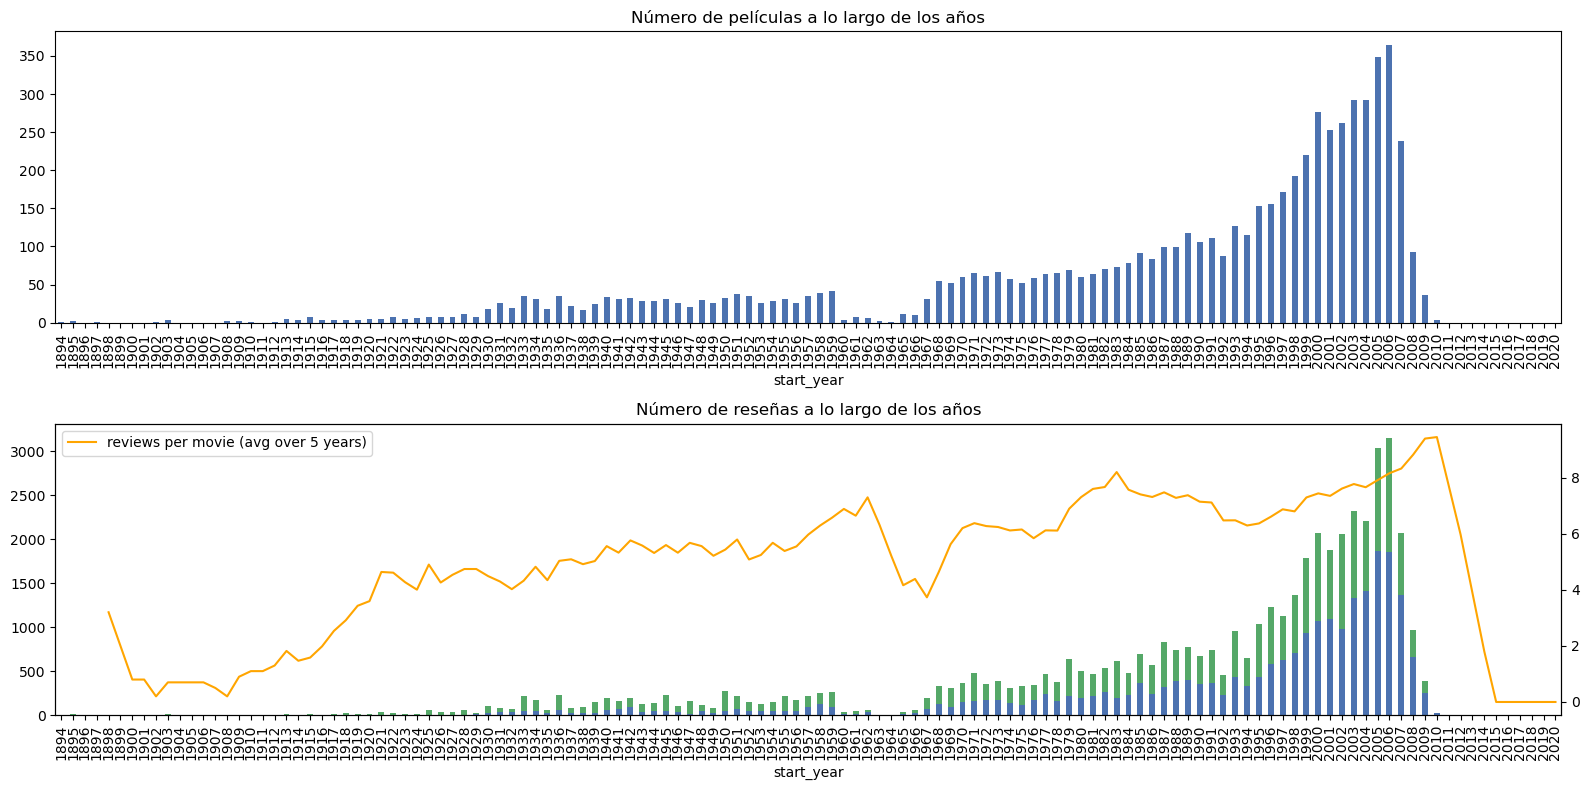

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Con esta gráfica se puede escalarecer algo. Existe un acervo de películas desde 1894 hasta el 2010. Sin embargo, la primera reseña existe para una película de 1895 y la tendencia creciente de producción de películas empezó hasta los años 1930 y creció de manera importante a partir de los daños 70s.

En el segundo subgráfico se puede observar la misma representación de las películas por año, pero aquí agregando nos fuentes de información. La primera que es una línea color naranja que representa la cantidad de reseñas por película, la cual, es constante y va de acuerdo a los estrenos, y por otro lado, en sentimiento (positivo o negativo) de estas reseñas. En general, se puede observar que las películas hasta finales del siglo XX recibieron muchas reseñas positivas, y que, los últimos años la crítica fue mucho más dura.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

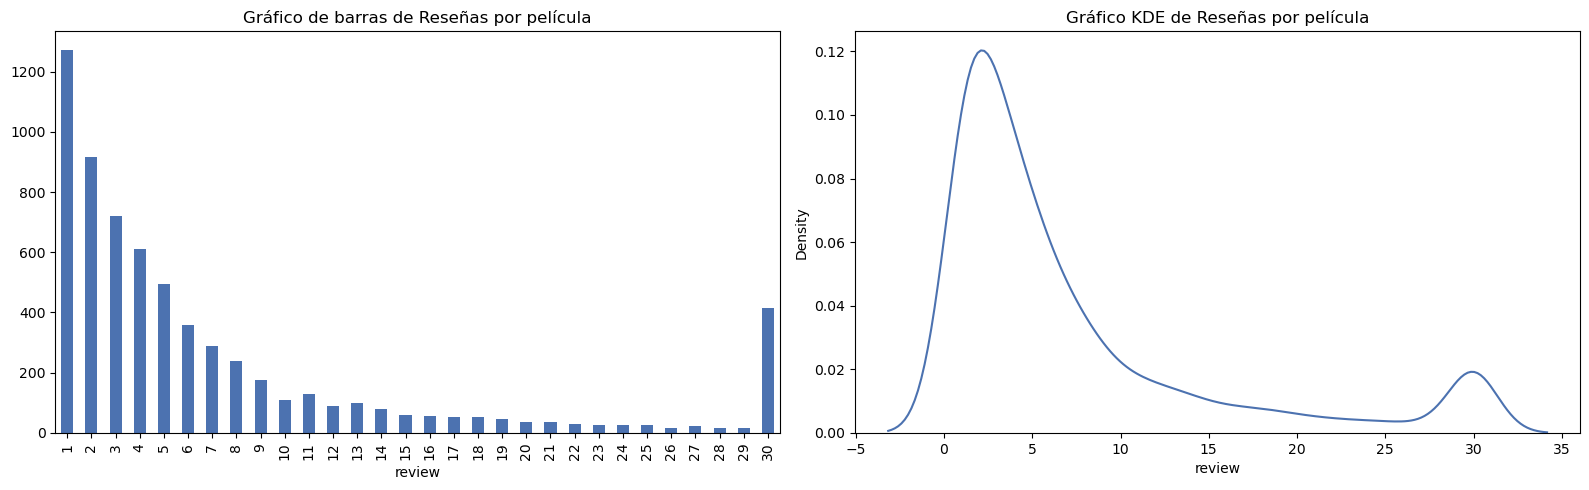

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de Reseñas por película')

fig.tight_layout()

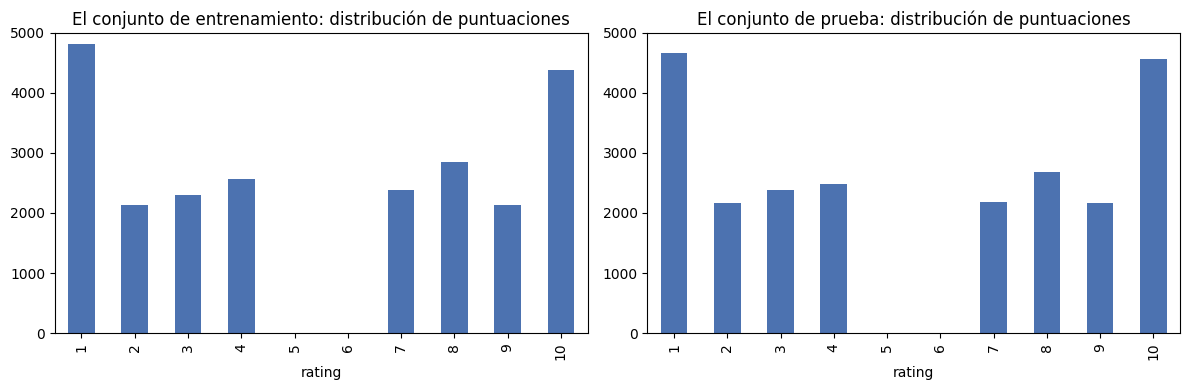

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

En las dos gráficas anteriores podemos ver:

* Gráfico de reseñas por películas: La gran mayoría de las películas tiene 1 reseña. A partir de 2, esta tendencia va decreciendo existiendo muy pocas películas con más de 10, sin embargo, al final hay un pico de películas con 30 reseñas, que probablemente corresponda a un tope del dataset (IMDB a veces limita a un máximo por título) o en su defecto, a una excelente o pésima película que la crítica no pudo omitir.

* Distribución de puntuaciones por conjuntos: Esto, como ya se había observado antes con el equilibrio de las clases, se muestra gráficamente, nos indica excelentes noticias donde existe un equilibrio casi perfecto en la distribución del rating en el conjunto de datos de entrenamiento, con relación al conjunto de datos que se usarán como prueba.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

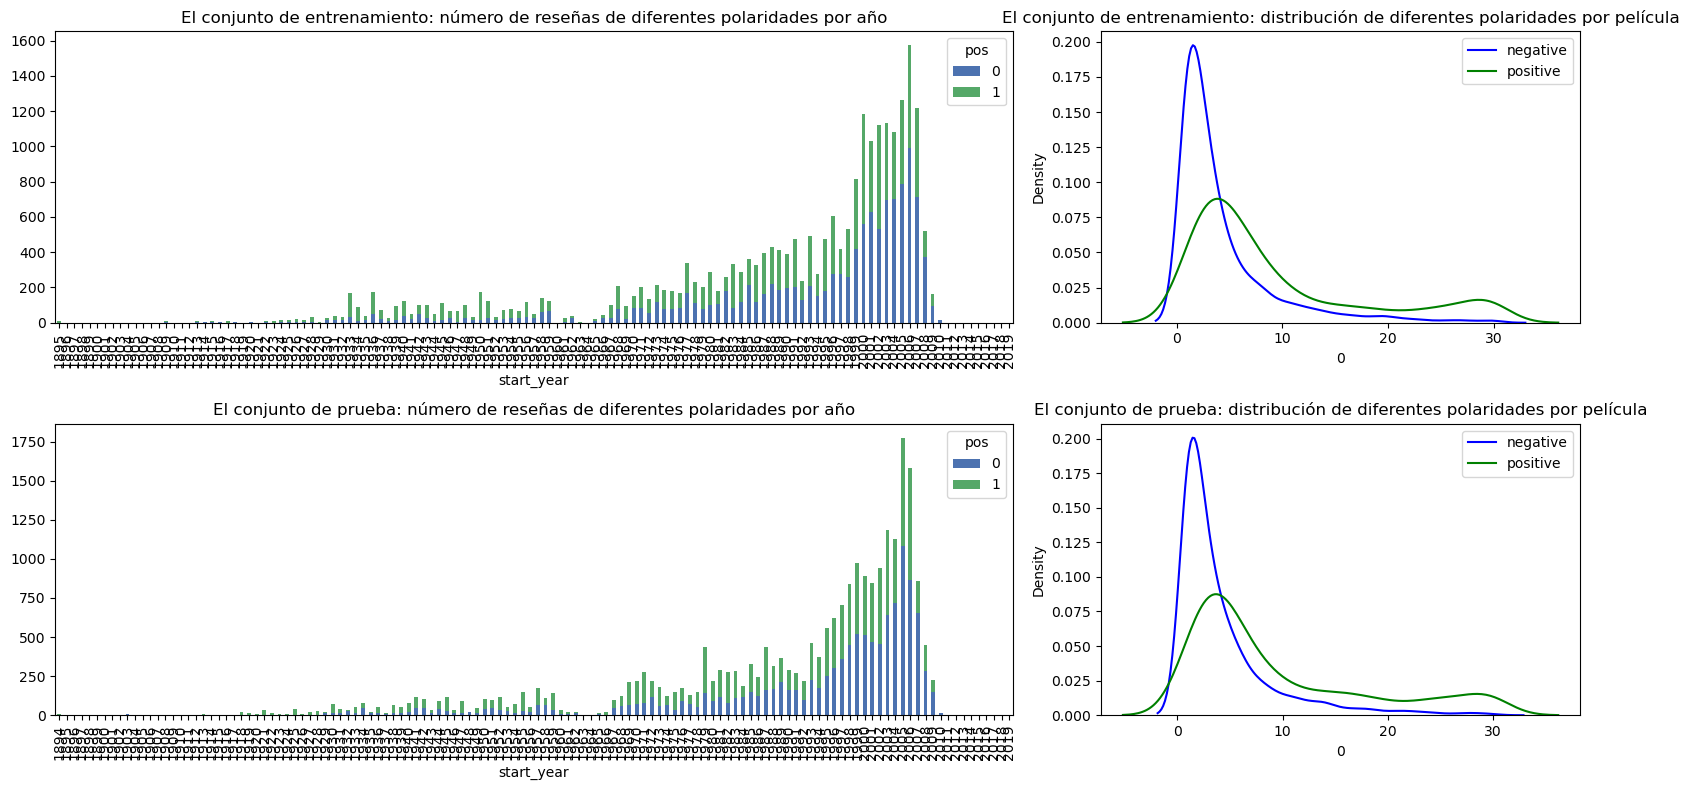

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Esta es una gráfica de conjunción de las dos primeras. Podemos ver la distribución de películas por año, su proporción de reseñas según sean positivas o negativas, y cómo estas están distribuídas en los dos conjuntos de datos. Todo luce perfecto.

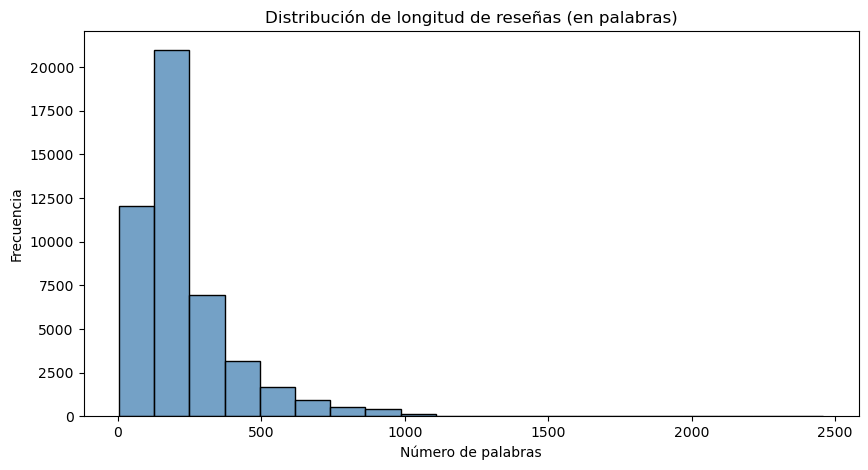

In [39]:
# Longitud de reseñas 
df_reviews['review_length'] = df_reviews['review'].str.split().str.len()

plt.figure(figsize=(10,5))
sns.histplot(df_reviews['review_length'], bins=20, kde=False, color='steelblue')
plt.title("Distribución de longitud de reseñas (en palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

En esta gráfica podemos ver la distribución de la longitud de la cantidad de palabras que existen en las reseñas. En general la mayoría de las reseñas tienen entre 100 y 200 palabras. Siguen las reseñas de menos de 100 palabras. Es muy raro ver reseñas con más de 200 palabras.

In [40]:
# Top palabras más frecuentes
def limpiar_texto(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)      # dejar solo letras
    return text

# Concatenar todas las reseñas en un solo string
all_text = " ".join(df_reviews['review'].dropna().map(limpiar_texto))

# Tokenizar
tokens = all_text.split()
# Sin stopwords
tokens_sin_sw = [t for t in tokens if t not in stop_words]
# Contar las 20 palabras con mayor frecuencia
freq = Counter(tokens_sin_sw)
top_words = freq.most_common(20)
print("Top 20 palabras:")
for palabra, cuenta in top_words:
    print(f"{palabra}: {cuenta}")

Top 20 palabras:
movie: 80983
film: 72101
one: 48351
like: 36699
good: 27121
even: 23112
would: 22566
time: 22439
really: 21602
see: 21264
story: 21170
well: 18021
much: 17932
get: 17137
bad: 17013
great: 16786
also: 16738
people: 16578
first: 16101
dont: 15924


Podemos ver que son palabras relacionadas a la emoción, y que probablemente la historia es una parte importante de la reseña.

In [41]:
display(df_reviews['title_type'].value_counts())
display(pd.crosstab(df_reviews['title_type'], df_reviews['pos'], normalize='index') * 100)

title_type
movie           36761
tvMovie          2877
video            2742
tvSeries         2073
short             857
tvMiniSeries      677
tvEpisode         635
tvSpecial         180
videoGame          23
tvShort            18
Name: count, dtype: int64

pos,0,1
title_type,,
movie,49.201600,50.798400
short,28.004667,71.995333
tvEpisode,33.070866,66.929134
tvMiniSeries,41.358936,58.641064
tvMovie,57.281891,42.718109
tvSeries,41.148095,58.851905
tvShort,44.444444,55.555556
tvSpecial,20.000000,80.000000
video,78.519329,21.480671


Aquí se puede ver que existe una variación entre el tipo de título y el sentimiento que provoca en la crítica. Para algunos tipos como los videojuegos, existen proporciones donde el 95% de aceptación, mientras que para videos, únicamente el 21% tiene una calificación positiva. Sin embargo, con el value_counts() podemos observer que, para los tipo de título que tienen la mayoría de las reseñas (movie, tv/movie, tv/series, etc) existe un balance justo. Por lo que, para la mayoría de las reseñas se puede decir que el tipo de título no  ayuda a diferenciar el sentimiento.

In [42]:
display(df_reviews['is_adult'].value_counts())
display(pd.crosstab(df_reviews['is_adult'], df_reviews['pos'], normalize='index') * 100)

is_adult
0    46761
1       82
Name: count, dtype: int64

pos,0,1
is_adult,,
0,50.212784,49.787216
1,43.902439,56.097561


Existe un balance, se puede decir que si el contenido es para adultos o no, no ayuda a predecir mucho la emoción. Además, únicamente 82 títulos sí son para adultos. Finalmente como se vió en las palabras clave, probablemente la palabra story pesa más. 

In [43]:
# Matriz de correlación entre la duración y el sentimiento
df_reviews[['runtime_minutes','pos']].corr()
# No existe una correlación. Se pudiera excluir esta columna para el modelo.

,runtime_minutes,pos
runtime_minutes,1.000000,0.049246
pos,0.049246,1.000000


## Preprocesamiento de los datos para el modelado


In [44]:
# Preparación del DataFrame para el modelo
df_model = df_reviews.copy()

In [45]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46843 entries, 0 to 47330
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           46843 non-null  object 
 1   title_type       46843 non-null  object 
 2   primary_title    46843 non-null  object 
 3   start_year       46843 non-null  int64  
 4   runtime_minutes  46843 non-null  float64
 5   is_adult         46843 non-null  int64  
 6   genres           46843 non-null  object 
 7   average_rating   46843 non-null  float64
 8   votes            46843 non-null  Int64  
 9   review           46843 non-null  object 
 10  rating           46843 non-null  int64  
 11  sp               46843 non-null  object 
 12  pos              46843 non-null  int64  
 13  ds_part          46843 non-null  object 
 14  review_length    46843 non-null  int64  
dtypes: Int64(1), float64(2), int64(5), object(7)
memory usage: 5.8+ MB


In [46]:
# La columna tconst no aporta información relevante para el modelo, se elimina.
df_model = df_model.drop(columns=['tconst'])
# Para el EDA, dejé primary_title, sin embargo, para el modelo, probablemente sea buena idea eliminar ambas.
df_model = df_model.drop(columns=['primary_title'])
# A pesar de que genres pudiera aportar información, es una columna con muchos valores únicos y no hay una relación MUY clara con el sentimiento.
df_model = df_model.drop(columns=['genres'])
# Columnas que pudieran causar data leakage:
df_model = df_model.drop(columns=['average_rating']) # Correlación moderada con pos (48), pero aún así es un valor derivado de las calificaciones.
df_model = df_model.drop(columns=['rating']) # La misma historia
# Durante el procesamiento de texto, con la tokenización ya estoy capturando esto, por lo que se elimina para el modelo.
df_model = df_model.drop(columns=['review_length'])
# Ya se había observado que sp es una columna de strings que corresponde perfectamente con pos. Se elimina.
df_model = df_model.drop(columns=['sp'])
# La columna votes crea un sesgo indirecto pues se relacion con la popularidad de la película. Y puede traducirse en el sentimiento. Se elimina.
df_model = df_model.drop(columns=['votes'])
# Anteriormente se hizo una matriz de correlación. La duración no tiene correlación con el sentimiento. Se elimina.
df_model = df_model.drop(columns=['runtime_minutes'])
# Ya se había discutido que para la mayoría, el tipo de título no ayuda a diferenciar el sentimiento. Se elimina.
df_model = df_model.drop(columns=['title_type'])
# is_adult no ayuda a predecir mucho la emoción. Se elimina.
df_model = df_model.drop(columns=['is_adult'])  
# Desde la primemra gráfica se puede ver que el desbalance de la fecha no es muy grande. No sirve como valor predictivo. Se elimina.
df_model = df_model.drop(columns=['start_year'])

In [47]:
corr_rat = df_reviews[['average_rating','pos']].corr().iloc[0,1]
print("Correlación entre avg_rating y pos:", corr_rat)

Correlación entre avg_rating y pos: 0.479985635995828


In [48]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46843 entries, 0 to 47330
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   review   46843 non-null  object
 1   pos      46843 non-null  int64 
 2   ds_part  46843 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


Tenemos el DataSet listo para hacer el preprocesamiento para texto.

### Normalización Básica de Texto

* **Minúsculas**
* **Evitar etiquetas HTML**
* **Sólo caracteres alfabéticos**
* **Reducción de espacios**

In [49]:
def normalizador_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"<br />", " ", texto)
    texto = re.sub(r"[^a-z\s]", " ", texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

df_model['review'] = df_model['review'].astype(str).apply(normalizador_texto)
df_model['review'].head(5)

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
Name: review, dtype: object

### Tokenización y crear una matriz

In [50]:
# TF-IDF Tiene su propio tokenizador
corpus = df_model['review'].tolist()
# Se llama a TfidfVectorizer()
count_vect_tfidf = TfidfVectorizer()
# Se ajusta y transforma el corpus con stopwords
bow_tfidf = count_vect_tfidf.fit_transform(corpus)
# Se muestra la forma de la matriz resultante
display(bow_tfidf.shape)
# Se hace lo mismo pero eliminando las stopwords
count_vect_tfidf_sw = TfidfVectorizer(stop_words='english')
# Ajuste
bow_tfidf_sw = count_vect_tfidf_sw.fit_transform(corpus)
# Forma final sin stopwords
display(bow_tfidf_sw.shape)
# Diferencia en número de características
diferencia = bow_tfidf.shape[1] - bow_tfidf_sw.shape[1]
print(f'Diferencia en número de características: {diferencia}')

(46843, 96612)

(46843, 96300)

Diferencia en número de características: 312


## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [51]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [52]:
df_model_train = df_model.query('ds_part == "train"').copy()
df_model_test = df_model.query('ds_part == "test"').copy()

train_target = df_model_train['pos']
test_target = df_model_test['pos']

print(df_model_train.shape)
print(df_model_test.shape)

diferencia_final = df_model_train.shape[0] + df_model_test.shape[0] - df_model.shape[0]
print(f'Diferencia en número de filas: {diferencia_final} COINCIDENCIAS, TODO BIEN.')

# División de los datos en conjunto de entrenamiento y prueba con literales
count_vect_tfidf_sw = TfidfVectorizer(stop_words='english')
# Ajustar con train y transformar
X_train = count_vect_tfidf_sw.fit_transform(df_model_train['review'])
X_test  = count_vect_tfidf_sw.transform(df_model_test['review'])
# Targets
y_train = df_model_train['pos']
y_test  = df_model_test['pos']

(23552, 3)
(23291, 3)
Diferencia en número de filas: 0 COINCIDENCIAS, TODO BIEN.


## Trabajar con modelos

### Modelo 0 - Constante

Modelo Dummy

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


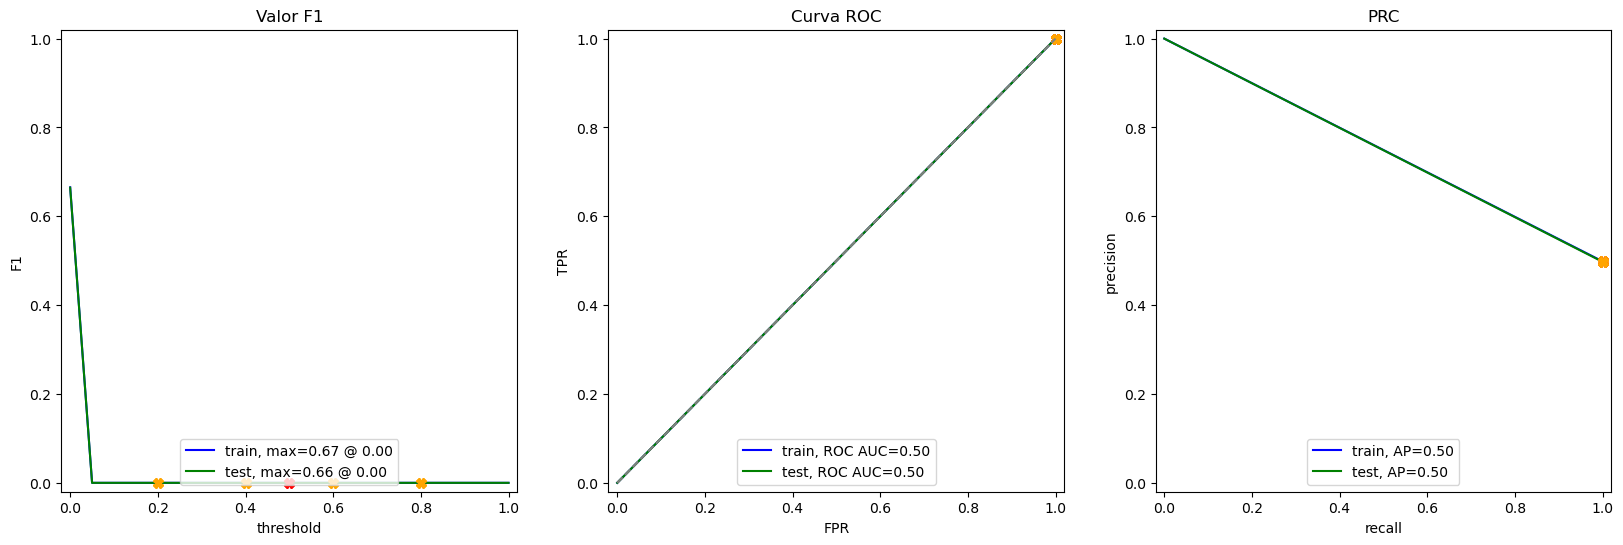

In [53]:
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
evaluate_model(dummy, X_train, y_train, X_test, y_test)

Un modelo muy sencillo con resultados que coinciden con lo esperado. Desde que se estaba haciendo en análisis exploratorio de los datos, me percaté que existe un balance de las clases casi perfecto.

* Accuracy = 0.5 (train y test): Siempre predice la clase mayoritaria. Por eso el modelo acierta el 50% de las veces simplemente porque siempre se va por una clase. Lo mismo se traduce cuando se hace el cálculo de la ROC AUC y su gráfica, que es una diagonal perfecta, que no tiene poder de discriminación ni de predicción real.

* F1 = 0.0 : No predice nunca la clase minoritaria (porque siempre elige la mayoritaria). Eso hace que el recall de una clase sea 0, y por tanto F1 se anule.

### Modelo 1 - LR con TF-IDF

Regresión Logística utilizando la Frecuencia de Término - Frecuencia inversa de documento. Ya se había aplicado el TfidfVectorizer.

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


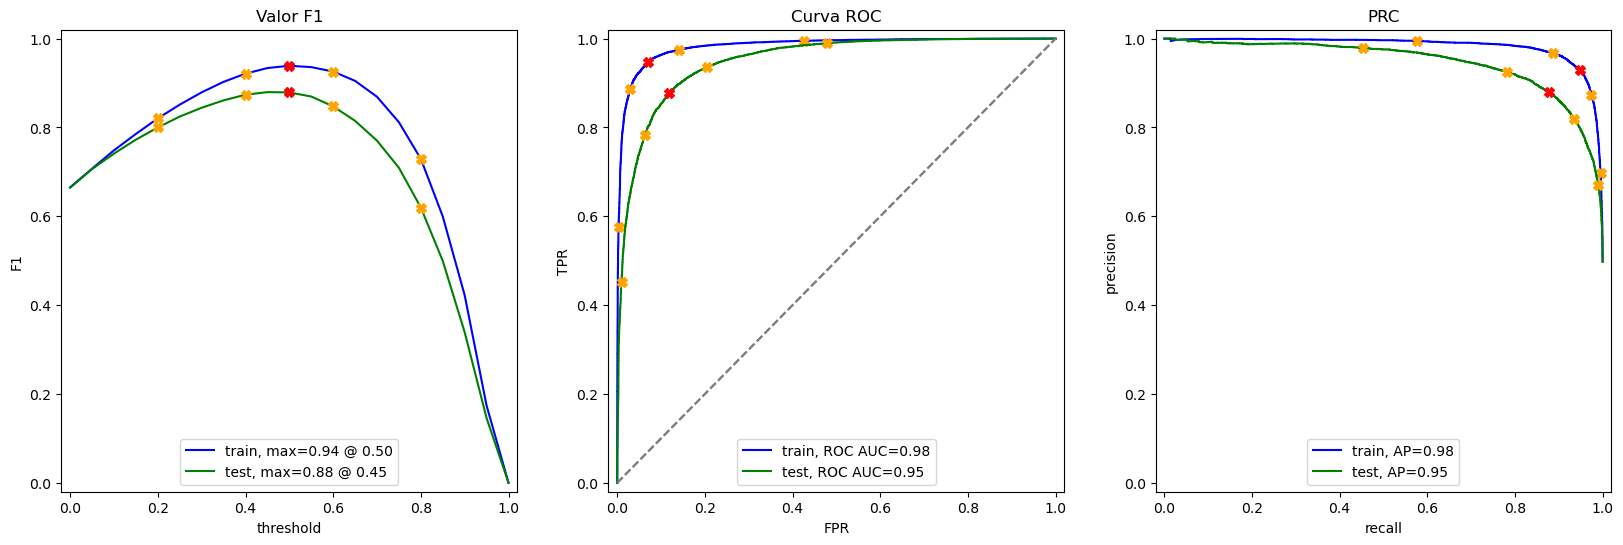

In [54]:
model_1 = LogisticRegression(random_state=42, max_iter=1000)
model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)
evaluate_model(model_1, X_train, y_train, X_test, y_test)

Cuando se entrena y se predice la emoción basado en la reseña por medio de la regresión logística puedo remarcar que, para el set de entrenamiento, se obtuvieron valores muy favorables (acc y F1 de 0.94 con ROC AUC de 0.98), y que en el set de prueba tuvo también resultados favorables, por lo menos, suficientes para satisfacer la métrica esperada en el proyecto. Estos valores son de esperarse, ya que existen una gran cantidad de valores tanto para el entrenamiento como para la prueba, además de fenómenos ya antes mencionados como un balance casi perfecto entre los datos de entrenamiento/prueba, las emociones, y las puntuaciones de estas emociones para estas dos secciones de datos.

Además, este es un problema de clasificación, en el cual, se pretende obtener un resultado o predicción con un resultado binario (emoción positiva/negativa) lo que también facilita que el algoritmo pueda tener un desempeño alto.

### Modelo 2 - RandomForestClassifier con TF-IDF 

Un RandomForestClassifier utilizando la Frecuencia de Término - Frecuencia inversa de documento. Ya se había aplicado el TfidfVectorizer.

          train  test
Accuracy    1.0  0.85
F1          1.0  0.84
APS         1.0  0.92
ROC AUC     1.0  0.93


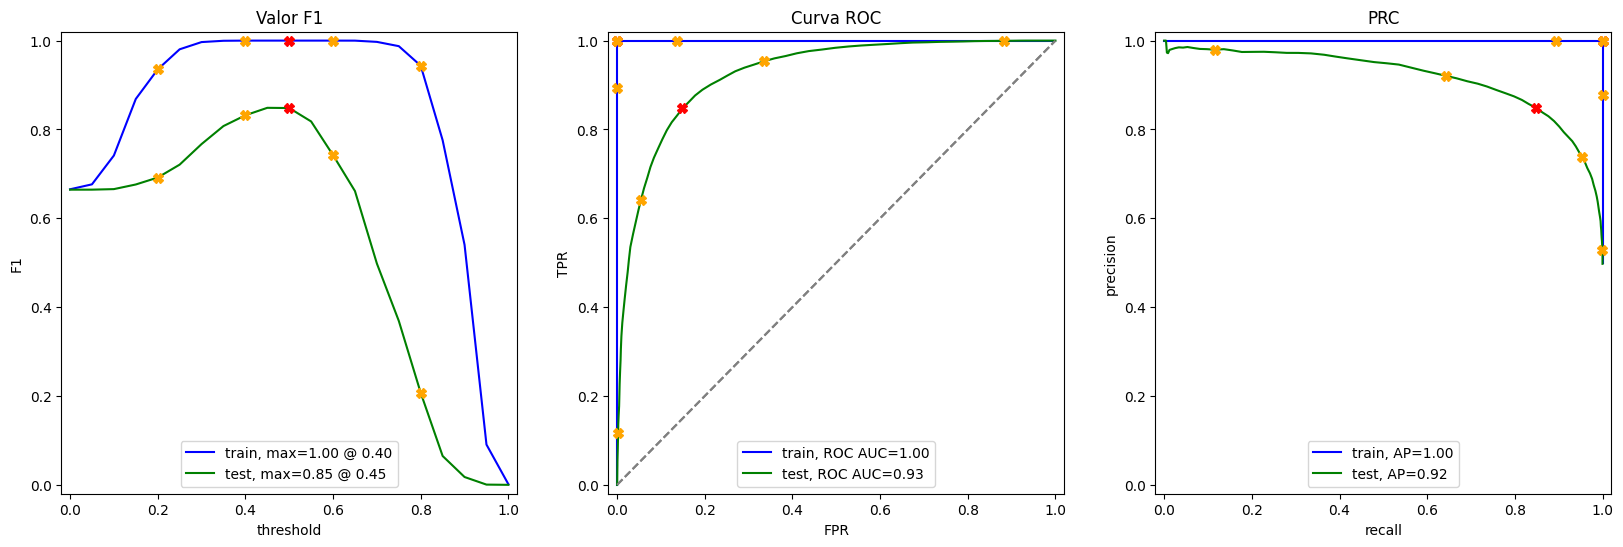

In [45]:
model_2 = RandomForestClassifier(random_state=42, n_jobs=-1)
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
evaluate_model(model_2, X_train, y_train, X_test, y_test)

El mismo fenómeno y comportamiento que se observó para la regresión lineal, se observó para el RandomForestClassifier, sin embargo, para el conjunto de prueba obtengo una F1 de 0.84, por que no satisface el resultado esperado para la métrica del proyecto. Por ende, se buscará otro algoritmo que pueda lograrlo.

Algo que se hace del notar, es que, para las métricas en el set de entrenamiento se obtienen resultados de 1 (perfecto). Un RandomForestClassifier tiene muchísima capacidad de memorización (que puede depender de la cantidad de árboles y su profundidad). En el conjunto de entrenamiento, los árboles pueden “aprender de memoria” lo que explica que la métrica sea "perfecta". Sin embargo, en el test, baja (acc de 0.85 y F1 de 0.84), lo cual nos puede indicar que existe overfitting. A pesar de ajustes de hiperparámetros para mitigar esto, es lógico que el desempeño sea menor que los modelos lineales (como la regresión lineal) ya que al intentar hacer análisis forjados a partir del lenguaje natural, la riqueza de las palabras en las reseñas y la diferencia de esta variedad entre ellas hace una matriz dispersa donde la mayoría de las celdas en esa matriz son 0 porque cada reseña usa pocas palabras del vocabulario total, lo que agrega ruido al algoritmo.

### Modelo 3 - TF-IDF y LGBMClassifier

A pesar de tener conocimento de cómo un modelo lineal tuvo un mejor desempeño que un modelo basado en árboles, se usará un LightGBMClassifier utilizando la misma técnica de TF-IDF.

[LightGBM] [Info] Number of positive: 11740, number of negative: 11812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.714058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484603
[LightGBM] [Info] Number of data points in the train set: 23552, number of used features: 11298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498471 -> initscore=-0.006114
[LightGBM] [Info] Start training from score -0.006114
          train  test
Accuracy   0.91  0.85
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


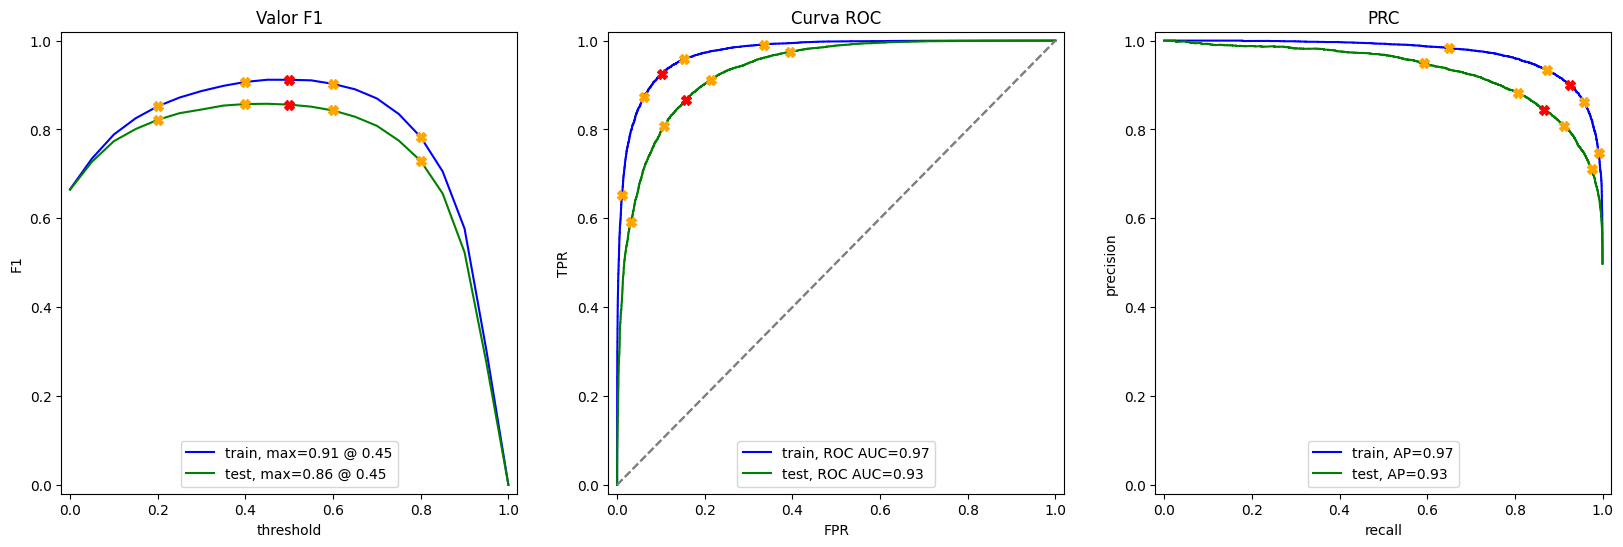

In [46]:
model_3 = LGBMClassifier(random_state=42, n_jobs=-1)
model_3.fit(X_train, y_train)
y_pred_3 = model_3.predict(X_test)
evaluate_model(model_3, X_train, y_train, X_test, y_test)

Como era de esperarse, las métricas obtenidas son satisfactorias. En este caso con un acc de 0.85 pero con una F1 de 0.86 sí se alcanza el desempeño que se soolicita para el proyecto, usando un algoritmo basado en árboles, sin embargo, ni con los datos de entrenamiento ni con los de prueba, se obtienen métricas mejores que el algoritmo lineal.

El uso de este algoritmo puede ser una buena idea si por ejemplo, se buscara satisfacer el objetivo utilizando árboles, pero también es cuestionalbe si usar unn algoritmo de gradient boosting justifica obtener una mejora métrica de 0.2 

### Modelo 4: TF-IDF con Catboost 

          train  test
Accuracy   0.94  0.86
F1         0.94  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


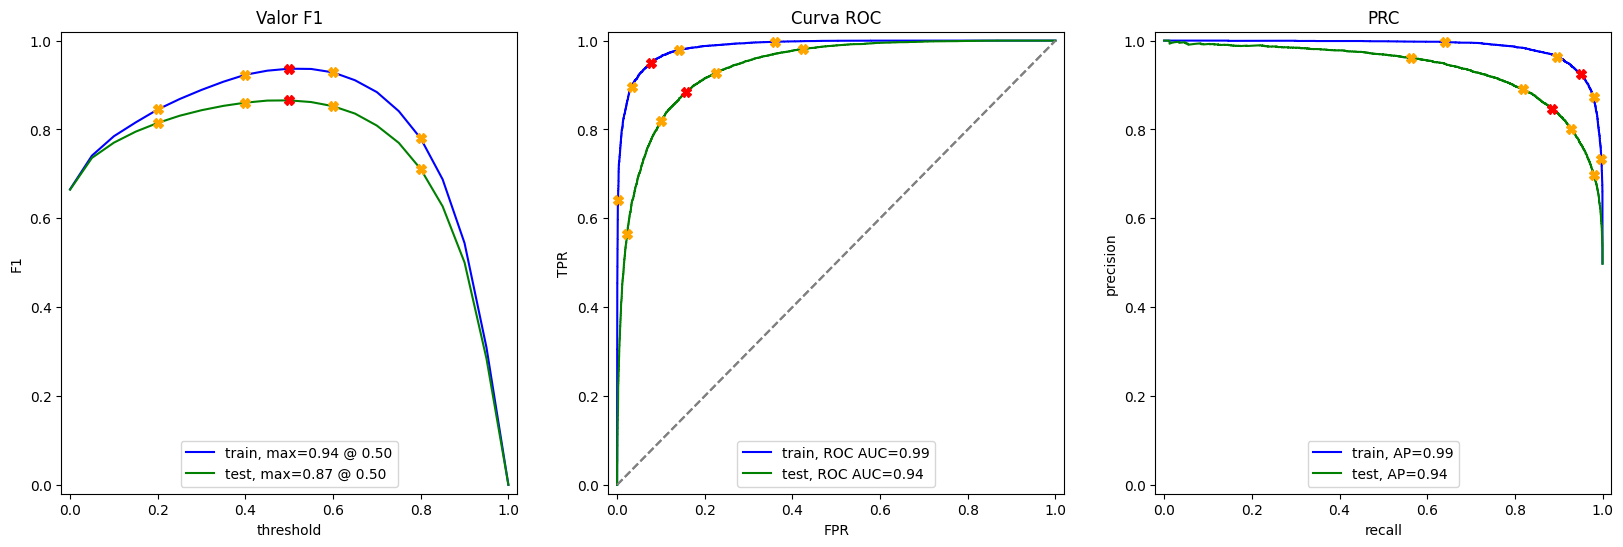

In [47]:
model_4 = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)
model_4.fit(X_train, y_train)
y_pred_4 = model_4.predict(X_test)
evaluate_model(model_4, X_train, y_train, X_test, y_test)

Con el catboost se obtienen métricas muy buenas de accuracy y F1 en el set de entrenamiento, y cuando se aplica en el set de prueba, las métricas equivalen a 0.87. Por lo menos para propósitos de estre proyecto, únicamente mejora la accuracy en 0.01, mientras que la métrica de interés (F1) se mantiene, además, el uso de este algoritmo hace uso de muchos recursos y requiere un mayor tiempo de cómputo, por lo cual, considero que en este escenario no es recomendable su uso.

### Modelo 5: TF-IDF con Stochastic Gradient Descent

Probemos otro algoritmo lineal:

          train  test
Accuracy   0.92  0.87
F1         0.92  0.87
APS        0.97  0.94
ROC AUC    0.97  0.95


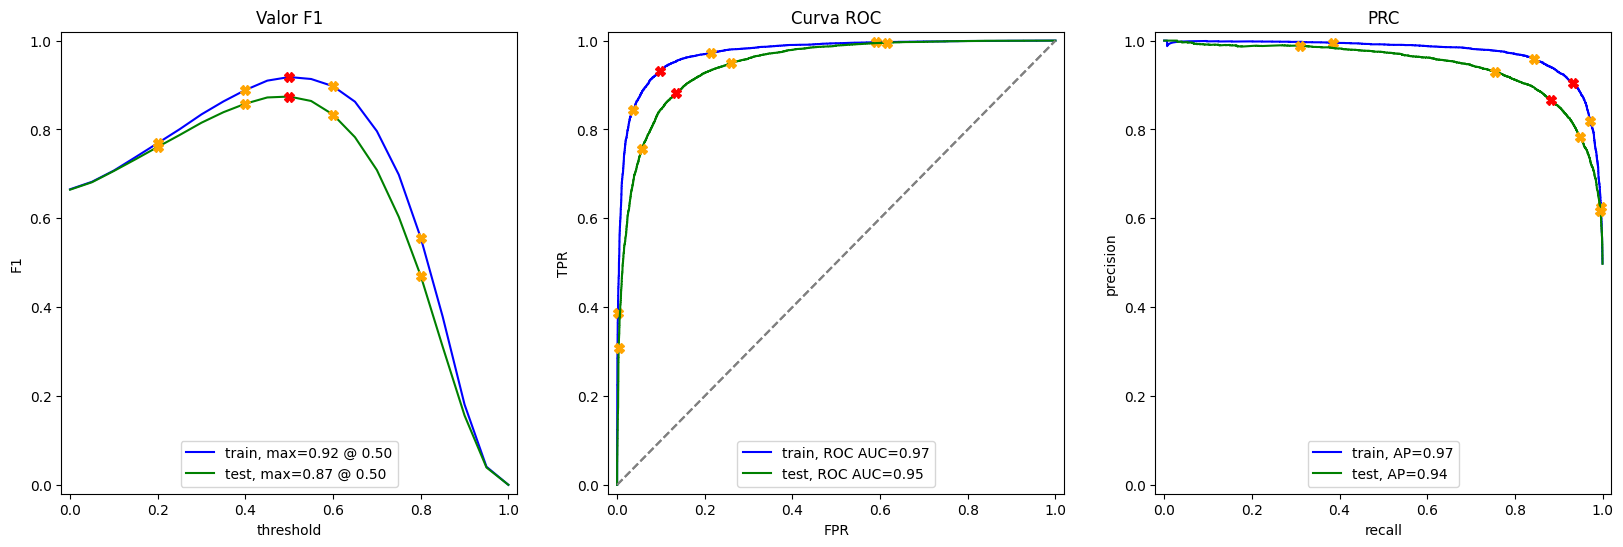

In [48]:
model_5 = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, tol=1e-3, random_state=42)
model_5.fit(X_train, y_train)
y_pred_5 = model_5.predict(X_test)
evaluate_model(model_5, X_train, y_train, X_test, y_test)

Se obtivo una F1 de 0.87, valor que es igual a los modelos donde se usaron los algoritmos basados en árboles. Sin embargo, las métricas resultaron mejor un la regresión logística, por lo cual, a pesar de ser una buena herramienta, la desición es priorizar la regresión logística sobre un modelo de descenso de gradiente estocástico. 

## Conclusiones

### Comparativa de modelos

| Modelo                               | Accuracy (test) | F1 (test) | ROC AUC (test) | AP (test) |
|--------------------------------------|----------------|-----------|----------------|-----------|
| DummyClassifier (baseline)           | 0.50           | 0.00      | 0.50           | 0.50      |
| Regresión Logística + TF-IDF         | **0.88**       | **0.88**  | **0.95**       | **0.95**  |
| Random Forest + TF-IDF               | 0.86           | 0.84      | 0.93           | 0.93      |
| LightGBM + TF-IDF                    | 0.86           | 0.86      | 0.93           | 0.93      |
| CatBoost + TF-IDF                    | 0.87           | 0.87      | 0.94           | 0.94      |
| SGDClassifier (Stochastic Gradient)  | 0.87           | 0.87      | 0.94           | 0.94      |


### Consideraciones finales

- El mejor modelo resultó ser **Regresión Logística con TF-IDF**, con F1 ≈ 0.88 en test.
- **CatBoost y SGDClassifier** mostraron un rendimiento muy competitivo (F1 ≈ 0.87), confirmando que los modelos lineales y los métodos de boosting funcionan bien en representaciones TF-IDF.
- **LightGBM** se comportó de manera sólida con F1 ≈ 0.86, mientras que **Random Forest** alcanzó un buen desempeño en test pero con **sobreajuste evidente** en train.
- El preprocesamiento básico con TF-IDF fue suficiente para lograr un rendimiento sólido, sin necesidad de modelos más costosos como BERT.